In [10]:
from pymatgen.core import Structure
import json

# Load from JSON
with open("w_ta_nb_elastic_data.json", "r") as f:
    dft_elastic_data = json.load(f)

# Convert structure_dict back into Structure objects and add them under "structure"
for k, v in dft_elastic_data.items():
    if "structure_dict" in v:
        v["structure"] = Structure.from_dict(v["structure_dict"])

In [11]:
selected_keys = ["W", "Ta", "Ta5NbW4", "Ta8NbW","Ta2NbW7","Ta3NbW6",'Ta6NbW3', 'Ta7NbW2', "TaNbW8",'Ta4NbW5']

# Filter elastic_moduli and stable_structures to selected keys
filtered_dft_structures = {k: dft_elastic_data[k] for k in selected_keys if k in dft_elastic_data}

In [ ]:
from fairchem.core import pretrained_mlip, FAIRChemCalculator
from pymatgen.io.ase import AseAtomsAdaptor
from ase.filters import FrechetCellFilter
from tqdm import tqdm
from elastic_utils import calculate_elasticity

predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cpu")
calc = FAIRChemCalculator(predictor, task_name="omat")

ev_to_gpa = 160.2176621
# Dictionary to store the results
mlp_elastic_moduli = {}

for name, entry in tqdm(filtered_dft_structures.items()):
    pmg_struct = entry['structure']
    # Convert to ASE Atoms
    atoms = AseAtomsAdaptor.get_atoms(pmg_struct)
    
    # Calculate elasticity
    results = calculate_elasticity(
        atoms,
        calculator=calc,
        cell_filter_cls=FrechetCellFilter,
        fix_symmetry=False,
    )
    
    # Convert to GPa
    shear_gpa = results['shear_modulus_vrh'] * ev_to_gpa
    bulk_gpa = results['bulk_modulus_vrh'] * ev_to_gpa
    pugh_ratio = shear_gpa/bulk_gpa
    
    # Store in dictionary
    mlp_elastic_moduli[name] = {
        'shear_modulus_vrh': shear_gpa,
        'bulk_modulus_vrh': bulk_gpa,
        'pugh_ratio': pugh_ratio
    }
    print(f"{name}: Shear = {shear_gpa:.2f} GPa, Bulk = {bulk_gpa:.2f} GPa, Pugh Ratio = {pugh_ratio:.2f}")

W0914 15:59:56.147000 18931 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
 11%|█         | 1/9 [00:21<02:50, 21.29s/it]

W: Shear = 149.95 GPa, Bulk = 304.02 GPa, Pugh Ratio = 0.49


 22%|██▏       | 2/9 [00:39<02:15, 19.41s/it]

Ta: Shear = 51.17 GPa, Bulk = 189.49 GPa, Pugh Ratio = 0.27


 33%|███▎      | 3/9 [02:10<05:12, 52.12s/it]

Ta8NbW: Shear = 50.42 GPa, Bulk = 196.08 GPa, Pugh Ratio = 0.26


 44%|████▍     | 4/9 [03:21<04:57, 59.43s/it]

Ta2NbW7: Shear = 109.42 GPa, Bulk = 273.11 GPa, Pugh Ratio = 0.40


 56%|█████▌    | 5/9 [04:36<04:20, 65.20s/it]

Ta3NbW6: Shear = 93.70 GPa, Bulk = 254.77 GPa, Pugh Ratio = 0.37


 67%|██████▋   | 6/9 [05:59<03:33, 71.28s/it]

Ta6NbW3: Shear = 59.88 GPa, Bulk = 214.59 GPa, Pugh Ratio = 0.28


 78%|███████▊  | 7/9 [07:26<02:32, 76.27s/it]

Ta7NbW2: Shear = 55.35 GPa, Bulk = 205.56 GPa, Pugh Ratio = 0.27


 89%|████████▉ | 8/9 [08:53<01:19, 79.86s/it]

TaNbW8: Shear = 125.49 GPa, Bulk = 286.49 GPa, Pugh Ratio = 0.44


100%|██████████| 9/9 [10:16<00:00, 68.46s/it]

Ta4NbW5: Shear = 81.83 GPa, Bulk = 239.08 GPa, Pugh Ratio = 0.34


In [6]:
import matplotlib.pyplot as plt
import random

selected_keys = ["W", "Ta", "Ta8NbW","Ta2NbW7","Ta3NbW6",'Ta6NbW3', 'Ta7NbW2', "TaNbW8",'Ta4NbW5','Ta5NbW4' ]

# Filter elastic_moduli and stable_structures to selected keys
filtered_mlp_moduli = {k: mlp_elastic_moduli[k] for k in selected_keys if k in mlp_elastic_moduli}
filtered_dft_results = {k: dft_elastic_data[k] for k in selected_keys if k in dft_elastic_data}

# Extract fractions and moduli
fractions = []
mlp_bulk_modulus_vrh = []
mlp_shear_modulus_vrh = []
mlp_pugh_ratio = []
dft_bulk_modulus_vrh = []
dft_shear_modulus_vrh = []
dft_pugh_ratio = []
for key in filtered_mlp_moduli:
    fractions.append(filtered_dft_results[key]['fractional_composition'].get('W', 0))
    ## MLP
    mlp_bulk_modulus_vrh.append(filtered_mlp_moduli[key]['bulk_modulus_vrh'])
    mlp_shear_modulus_vrh.append(filtered_mlp_moduli[key]['shear_modulus_vrh'])
    mlp_pugh_ratio.append(filtered_mlp_moduli[key]['pugh_ratio'])
    ## DFT
    dft_bulk_modulus_vrh.append(filtered_dft_results[key]['k_vrh'])
    dft_shear_modulus_vrh.append(filtered_dft_results[key]['g_vrh'])
    dft_pugh_ratio.append(filtered_dft_results[key]['g_vrh']/filtered_dft_results[key]['k_vrh'])

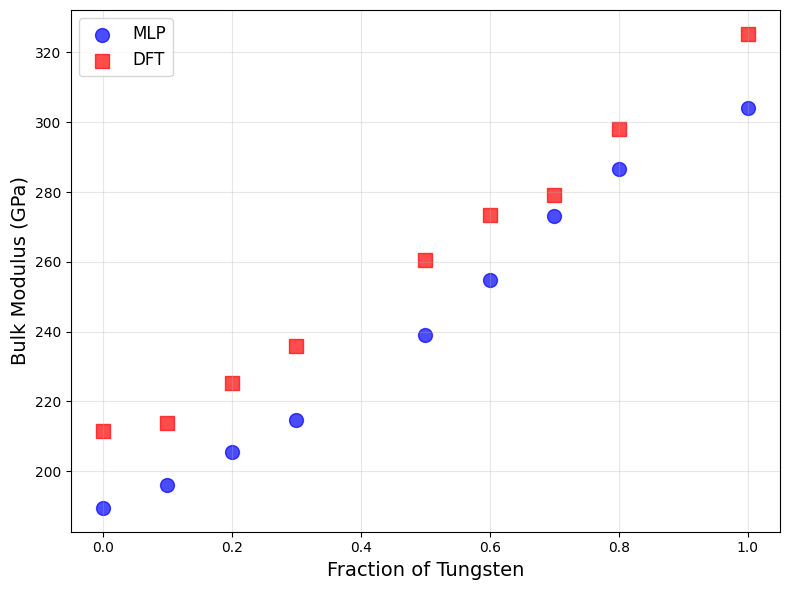

In [7]:
# Bulk modulus vs fraction W (MLP vs DFT)
plt.figure(figsize=(8, 6))

# MLP points
plt.scatter(fractions, mlp_bulk_modulus_vrh, color='blue', s=100, alpha=0.7, label="MLP")

# DFT points
plt.scatter(fractions, dft_bulk_modulus_vrh, color='red', s=100, alpha=0.7, marker='s', label="DFT")

# # Labels for each point (optional: only for MLP to avoid clutter)
# for i, key in enumerate(filtered_mlp_moduli):
#     offset_x = random.uniform(0, 0.02)
#     offset_y = random.uniform(0, 2)
#     plt.text(
#         fractions[i] + offset_x,
#         mlp_bulk_modulus_vrh[i] + offset_y,
#         key,
#         fontsize=12
#     )

plt.xlabel('Fraction of Tungsten', fontsize=14)
plt.ylabel('Bulk Modulus (GPa)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

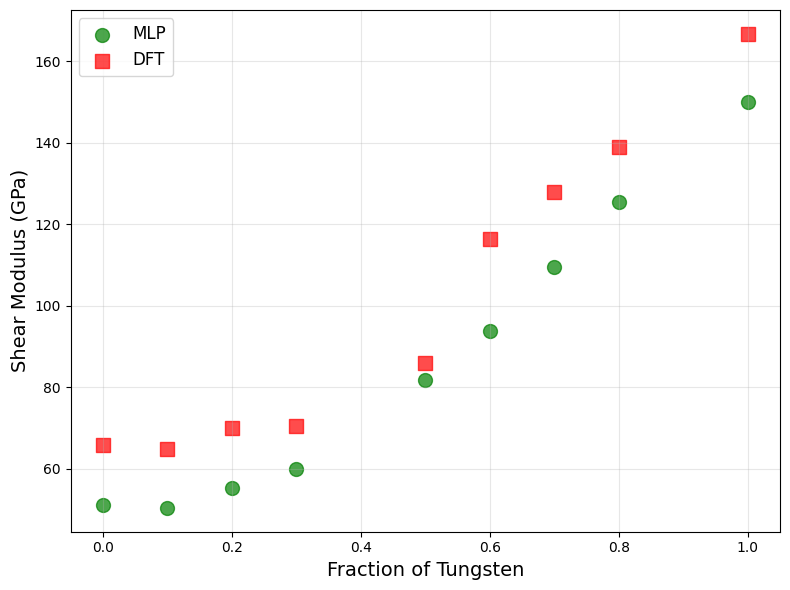

In [8]:
# 2) Shear modulus vs fraction W
plt.figure(figsize=(8, 6))

# MLP values
plt.scatter(fractions, mlp_shear_modulus_vrh, color='green', s=100, alpha=0.7, label="MLP")

# DFT values
plt.scatter(fractions, dft_shear_modulus_vrh, color='red', s=100, alpha=0.7, marker='s', label="DFT")

# # Single label per system (placed between MLP & DFT values)
# for i, key in enumerate(filtered_mlp_moduli):
#     offset_x = random.uniform(0, 0.02)
#     offset_y = random.uniform(0, 2)
#     y_mid = 0.5 * (mlp_shear_modulus_vrh[i] + dft_shear_modulus_vrh[i])  # midpoint
#     plt.text(
#         fractions[i] + offset_x,
#         y_mid + offset_y,
#         key,
#         fontsize=12,
#         color='black'
#     )

plt.xlabel('Fraction of Tungsten', fontsize=14)
plt.ylabel('Shear Modulus (GPa)', fontsize=14)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


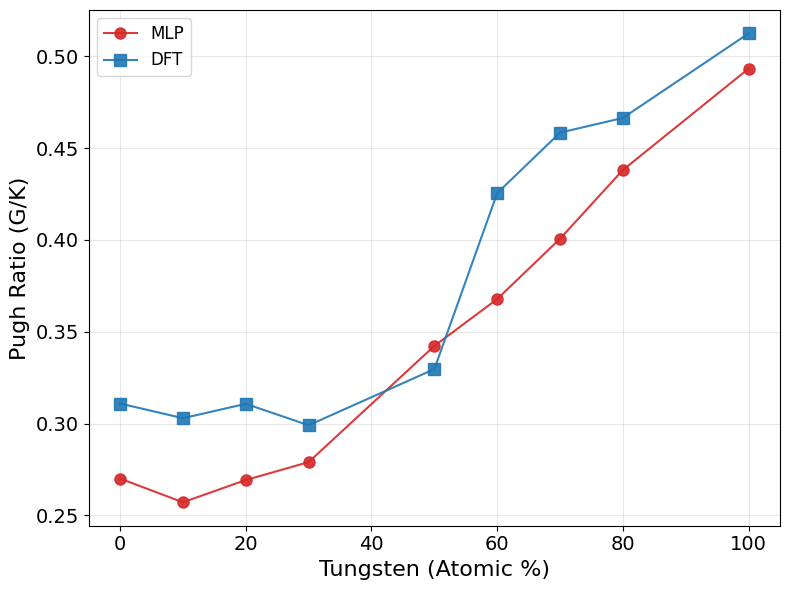

In [9]:
# 3) Pugh ratio vs fraction W (MLP + DFT)
mlp_pugh_ratio = [mlp_shear_modulus_vrh[i] / mlp_bulk_modulus_vrh[i] for i in range(len(fractions))]
dft_pugh_ratio = [dft_shear_modulus_vrh[i] / dft_bulk_modulus_vrh[i] for i in range(len(fractions))]

# Sort data by fractions for proper line connections
import numpy as np
sorted_indices = np.argsort(fractions)
sorted_fractions = np.array(fractions)[sorted_indices]*100
sorted_mlp_pugh = np.array(mlp_pugh_ratio)[sorted_indices]
sorted_dft_pugh = np.array(dft_pugh_ratio)[sorted_indices]

plt.figure(figsize=(8, 6))

# Plot MLP values with lines
plt.plot(sorted_fractions, sorted_mlp_pugh, 'o-', color='tab:red', markersize=8, alpha=0.9, label="MLP")

# Plot DFT values with lines
plt.plot(sorted_fractions, sorted_dft_pugh, 's-', color='tab:blue', markersize=8, alpha=0.9, label="DFT")

# # One label per system (positioned for MLP, applies to DFT as well)
# for i, key in enumerate(filtered_mlp_moduli):
#     offset_x = random.uniform(0, 0.02)
#     offset_y = random.uniform(0, 0.02)
#     plt.text(
#         fractions[i] + offset_x,
#         max(mlp_pugh_ratio[i], dft_pugh_ratio[i]) + offset_y,  # place above the higher value
#         key,
#         fontsize=12,
#         color='black'
#     )

plt.xlabel('Tungsten (Atomic %)', fontsize=16)
plt.ylabel('Pugh Ratio (G/K)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
from ase.visualize import view
from pymatgen.io.ase import AseAtomsAdaptor
view(AseAtomsAdaptor.get_atoms(dft_elastic_data['Ta4NbW5']['structure']).repeat(2), viewer="x3d") 

In [ ]:
view(AseAtomsAdaptor.get_atoms(dft_elastic_data['Ta3NbW6']['structure']).repeat(2), viewer="x3d") 